# Chapter 6 학습 관련 기술들

## 6.1 매개변수 갱신

### 6.1.2 확률적 경사 하강법(SGD)
$W ⬅ W - \eta\frac{\partial L}{\partial W} $

In [ ]:
# 구현
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]
            

SGD의 단점은 비등방성함수에서는 탐색 경로가 비효율적이라는것.<br/>
이를 개선한게 모멘텀, AdaGrad, Adam

### 6.1.4 모멘텀
$v ⬅ \alpha v - \eta\frac{\partial L}{\partial W} $ <br/>
$W ⬅ W + v $

In [ ]:
# 구현
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]
            

### 6.1.5 AdaGrad
$h ⬅ h + \frac{\partial L}{\partial W} ⊙ \frac{\partial L}{\partial W} $<br/>
$W ⬅ W - \eta \frac{1}{\sqrt h} \frac{\partial L}{\partial W} $
* 각각의 매개변수에 적응적으로 '학습률'을 조정하면서 학습을 진행


In [ ]:
# 구현
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

### 6.1.6 Adam
* 모멘텀과 AdaGGrad를 융합한 듯한 방법
* 하이퍼파라미터의 '편향 보정'

In [ ]:
# 구현
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])

            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

### RMSprop
* AdaGrad에서 과거 값을 점점 잊어가면서 갱신
* 이를 지수이동평균이라 하며, 과거 기울기의 반영 규모를 기하급수적으로 감소시킴

In [ ]:
# 구현
class RMSprop:
    def __init__(self, lr =0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

### 6.1.7 갱신 방법 비교

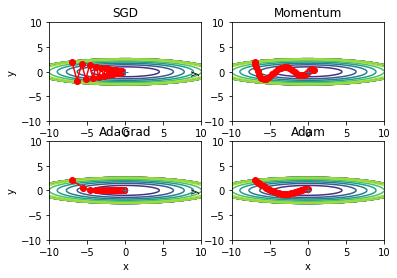

In [5]:
import sys, os
path = '/content/drive/MyDrive/DL_from_bottom'
os.chdir(path)
sys.path.append(os.chdir)

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.optimizer import *
from common.layers import *


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1
for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0
    
    # 그래프 그리기
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

### 6.1.8 MNIST 데이터셋으로 본 갱신 방법 비교

In [ ]:
class MultiLayerNet:
    """완전연결 다층 신경망

    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    weight_decay_lambda : 가중치 감소(L2 법칙)의 세기
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.weight_decay_lambda = weight_decay_lambda
        self.params = {}

        # 가중치 초기화
        self.__init_weight(weight_init_std)

        # 계층 생성
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
            self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """가중치 초기화
        
        Parameters
        ----------
        weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
            'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
            'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLU를 사용할 때의 권장 초깃값
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoid를 사용할 때의 권장 초깃값
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블 
        
        Returns
        -------
        손실 함수의 값
        """
        y = self.predict(x)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        """기울기를 구한다(수치 미분).
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        
        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        
        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grads

===========iteration:0============
SGD:2.4759593712312666
Momentum:2.334167565062682
AdaGrad:2.259375754597254
Adam:2.1330614906648835
RMSprop:13.725565812925442
===========iteration:100============
SGD:1.3410029266017411
Momentum:0.331394246420999
AdaGrad:0.06838399782481341
Adam:0.14547680720935607
RMSprop:0.1486014900813633
===========iteration:200============
SGD:0.6151240884700298
Momentum:0.2250412600087935
AdaGrad:0.09610230420165547
Adam:0.18138021786637737
RMSprop:0.1233444242469752
===========iteration:300============
SGD:0.5887247748745017
Momentum:0.30559402706431915
AdaGrad:0.10937872273863866
Adam:0.24689039696280754
RMSprop:0.3252579072030184
===========iteration:400============
SGD:0.44014869913923044
Momentum:0.21126855407199416
AdaGrad:0.09348995799559498
Adam:0.11153537461700931
RMSprop:0.1792117539632145
===========iteration:500============
SGD:0.3718846000811681
Momentum:0.17683701546835134
AdaGrad:0.08308054171604767
Adam:0.10601840833197662
RMSprop:0.126220792629

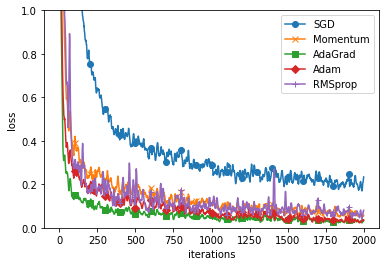

In [ ]:
from dataset.mnist import load_mnist
from common.util import smooth_curve
# from.multi_layer_net import MultiLayerNet

# MNIST 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)  # 원핫 인코딩 안함

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

# 실험용 설정
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []

# 훈련
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)

        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)

    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "============")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

# 그래프 그리기
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D", "RMSprop": "+"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()


SGD를 제외한 나머지는 비슷한 결과를 보여줌.<br/>
하이퍼파라미터인 학습률과 신경망의 구조(층 깊이 등)에 따라 결과가 달라질 수 있다.

## 6.2 가중치의 초깃값

### 6.2.1 초깃값을 0으로 하면
* 가중치를 모두 같은 값으로 두면 오차역전파법에서 모든 가중치의 값이 똑같이 갱신됨.
* 따라서 초깃값을 무작위로 설정할 필요가 있음.

### 6.2.2 은닉층의 활성화값 분포
* 가중치의 초깃값에 따라 은닉층 활성화값들이 어떻게 변화하는지 관찰
* 시그모이드 함수를 사용하는 5층 신경망을 통해 시험할 예정

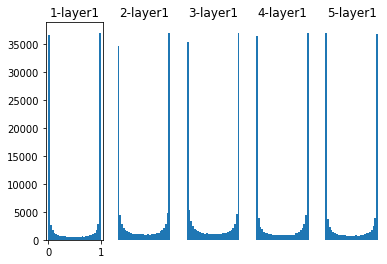

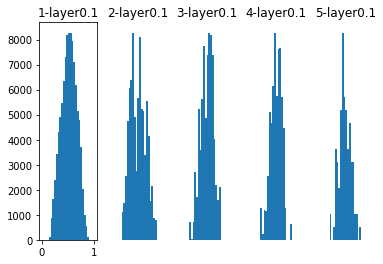

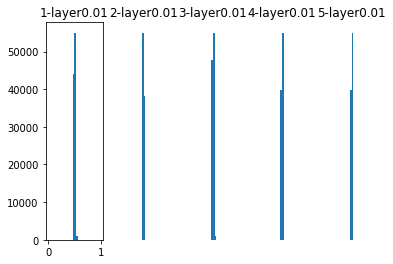

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100                  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5           # 은닉층 5개
activations = {}                # 활성화값 저장

for r in [1, 0.1, 0.01]:
    for i in range(hidden_layer_size):
        if i != 0:
            x = activations[i-1]

        w = np.random.randn(node_num, node_num) * r

        a = np.dot(x, w)
        z = sigmoid(a)
        activations[i] = z

    # 히스토그램 그리기
    for i, a in activations.items():
        plt.subplot(1, len(activations), i+1)
        plt.title(str(i+1) + "-layer" + str(r))
        plt.hist(a.flatten(), 30, range=(0,1))

        if i != 0:
            plt.axis('off')
    plt.show()

위 첫번째 히스토그램을 보면 기울기 소실 문제를 관찰할 수 있음.(gradient vanishing) <br/>
세번째 히스토그램을 보면 활성화값들이 치우치면서 표현력을 제한하는 문제 발생

Xavier 초깃값 활용
* 앞 계층의 노드가 n개면 표준편차가 $\frac{1}{\sqrt n}$인 분포를 사용
* 실제 사비에르의 논문에서는 다음 층의 노드 수도 고려했지만, 카페 등의 프레임워크는 앞 층의 입력 노드만으로 계산하도록 단순화함

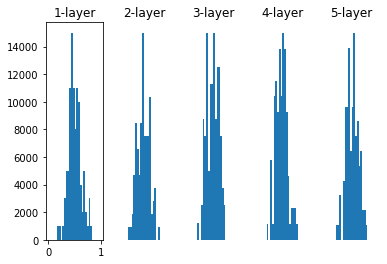

In [ ]:

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)

    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))

    if i != 0:
            plt.axis('off')
            
plt.show()

tanh 함수를 사용하면 좀 더 개선됨

### 6.2.3 ReLU를 사용할 때의 가중치 초깃값
* Xavier 초깃값은 활성화 함수가 선형인 것을 전제로 이끈 결과.
* Sigmoid와 tanh 함수는 중앙 부근이 선형인 함수로 볼 수 있음.
* ReLu는 He 초깃값을 사용함.<br/>
표준편차가 $\sqrt \frac{2}{n}$인 정규분포 사용

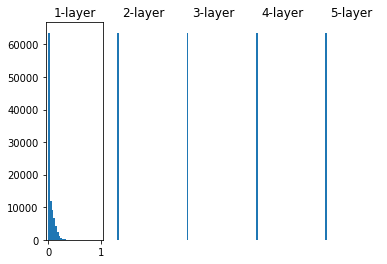

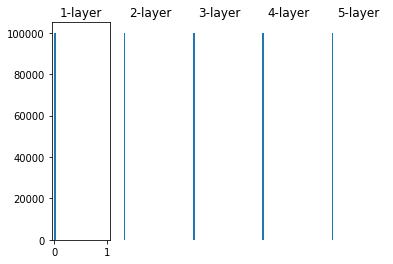

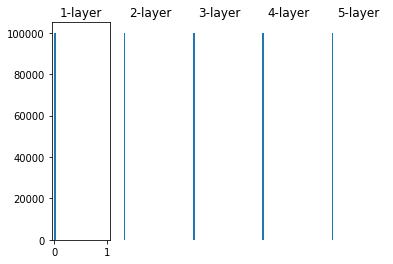

In [ ]:
def relu(x):
    return np.maximum(0, x)

x = np.random.randn(1000, 100) 
node_num = 100                 
hidden_layer_size = 5          
activations = {}               

for r in [0.01, 1/np.sqrt(node_num), np.sqrt(2/node_num)]:
    for i in range(hidden_layer_size):
        if i != 0:
            x = activations[i-1]

        w = np.random.randn(node_num, node_num) * r

        a = np.dot(x, w)
        z = relu(a)
        activations[i] = z

    # 히스토그램 그리기
    for i, a in activations.items():
        plt.subplot(1, len(activations), i+1)
        plt.title(str(i+1) + "-layer")
        plt.hist(a.flatten(), 30, range=(0,1))

        if i != 0:
            plt.axis('off')
    plt.show()


히스토그램에 결과가 제대로 안나온것 같지만 책을 기준으로 적자면 
* std=0.01일 때는 각 층의 활성화값들이 아주 작은 값들임. 즉, 역전파 때 가중치의 기울기 역시 작아진다는 뜻. 결과로 학습이 거의 이뤄지지 않을 것.
* std=Xavier일땐 층이 깊어짐에 따라 치우침이 커짐. 그에 따라 활성화값들의 치우침도 커지고, 학습할 때 기울기 소실 문제를 일으킴
* std=He일땐 모든 층에서 균일하게 분포

### 6.2.4 MNIST 데이터셋으로 본 가중치 초깃값 비교

============iteration:0============
std=0.01:2.3025059029340023
Xavier:2.306924801643112
He:2.4535760348611566
============iteration:100============
std=0.01:2.3019204707105416
Xavier:2.2421224871933725
He:1.4505760910027872
============iteration:200============
std=0.01:2.301079792041009
Xavier:2.11473313683824
He:0.7649316792690022
============iteration:300============
std=0.01:2.3019246802877724
Xavier:1.6963226633075479
He:0.5622387324247239
============iteration:400============
std=0.01:2.2997667131486637
Xavier:1.263738459281353
He:0.4391891681775134
============iteration:500============
std=0.01:2.3017363985662933
Xavier:0.8646337666165282
He:0.46282265958695346
============iteration:600============
std=0.01:2.30200710748211
Xavier:0.6530400148880593
He:0.34607886039390795
============iteration:700============
std=0.01:2.3076465639582677
Xavier:0.6381162689588713
He:0.30125679852065346
============iteration:800============
std=0.01:2.3044232718021407
Xavier:0.5230870428649123
He

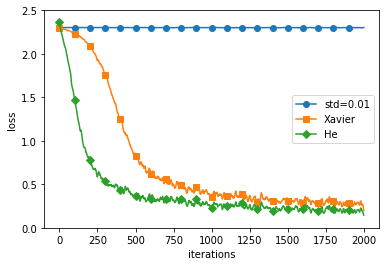

In [ ]:
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

# 실험용 설정
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []

# 훈련
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)

        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)

    if i % 100 == 0:
        print("============" + "iteration:" + str(i) + "============")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

# 그래프 그리기
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

앞에서 관찰한 것과 같이 std=0.01일때는 학습이 전혀 이루어지지 않았음.

## 6.3 배치 정규화
* 각 층의 황성화를 적당히 퍼뜨리도록 '강제'하는 방법
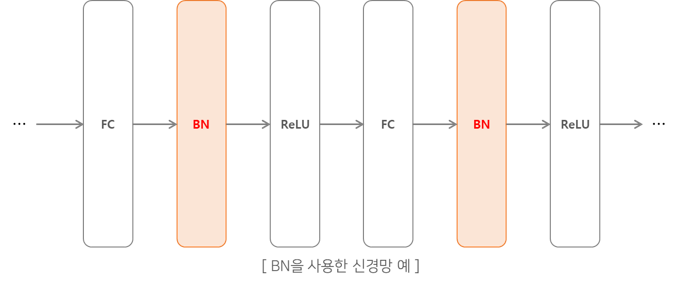

[관련 논문](https://arxiv.org/pdf/1502.03167v3.pdf)

* 배치 정규화는 미니배치를 단위로 정규화함.
* 정확히는 데이터 분포가 평균이 0, 분산이 1이 되도록 정규화
* 배치 정규화 계층마다 이 정규화된 데이터에 고유한 확대와 이동변환을 수행

### 6.3.2 배치 정규화의 효과

============== 1/16 ==============
epoch:0 | 0.092 - 0.099


/content/drive/MyDrive/DL_from_bottom/common/functions.py:34: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)


epoch:1 | 0.097 - 0.083
epoch:2 | 0.097 - 0.113
epoch:3 | 0.097 - 0.127
epoch:4 | 0.097 - 0.145
epoch:5 | 0.097 - 0.17
epoch:6 | 0.097 - 0.196
epoch:7 | 0.097 - 0.207
epoch:8 | 0.097 - 0.231
epoch:9 | 0.097 - 0.25
epoch:10 | 0.097 - 0.27
epoch:11 | 0.097 - 0.289
epoch:12 | 0.097 - 0.302
epoch:13 | 0.097 - 0.32
epoch:14 | 0.097 - 0.33
epoch:15 | 0.097 - 0.347
epoch:16 | 0.097 - 0.357
epoch:17 | 0.097 - 0.383
epoch:18 | 0.097 - 0.392


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.412
============== 2/16 ==============
epoch:0 | 0.093 - 0.097


/content/drive/MyDrive/DL_from_bottom/common/multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/content/drive/MyDrive/DL_from_bottom/common/multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


epoch:1 | 0.097 - 0.143
epoch:2 | 0.097 - 0.154
epoch:3 | 0.097 - 0.163
epoch:4 | 0.097 - 0.171
epoch:5 | 0.097 - 0.192
epoch:6 | 0.097 - 0.223
epoch:7 | 0.097 - 0.24
epoch:8 | 0.097 - 0.263
epoch:9 | 0.097 - 0.29
epoch:10 | 0.097 - 0.311
epoch:11 | 0.097 - 0.332
epoch:12 | 0.097 - 0.348
epoch:13 | 0.097 - 0.37
epoch:14 | 0.097 - 0.388
epoch:15 | 0.097 - 0.398
epoch:16 | 0.097 - 0.417
epoch:17 | 0.097 - 0.444
epoch:18 | 0.097 - 0.463


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.463
============== 3/16 ==============
epoch:0 | 0.105 - 0.079
epoch:1 | 0.374 - 0.072
epoch:2 | 0.527 - 0.11
epoch:3 | 0.646 - 0.165
epoch:4 | 0.689 - 0.211
epoch:5 | 0.759 - 0.259
epoch:6 | 0.797 - 0.299
epoch:7 | 0.849 - 0.339
epoch:8 | 0.877 - 0.37
epoch:9 | 0.892 - 0.407
epoch:10 | 0.922 - 0.442
epoch:11 | 0.926 - 0.474
epoch:12 | 0.943 - 0.498
epoch:13 | 0.951 - 0.52
epoch:14 | 0.962 - 0.552
epoch:15 | 0.972 - 0.556
epoch:16 | 0.98 - 0.586
epoch:17 | 0.978 - 0.602
epoch:18 | 0.985 - 0.613


No handles with labels found to put in legend.


epoch:19 | 0.984 - 0.642
============== 4/16 ==============
epoch:0 | 0.117 - 0.095
epoch:1 | 0.243 - 0.106
epoch:2 | 0.387 - 0.138
epoch:3 | 0.508 - 0.233
epoch:4 | 0.565 - 0.288
epoch:5 | 0.603 - 0.364
epoch:6 | 0.639 - 0.413
epoch:7 | 0.677 - 0.462
epoch:8 | 0.703 - 0.503
epoch:9 | 0.723 - 0.537
epoch:10 | 0.746 - 0.582
epoch:11 | 0.764 - 0.613
epoch:12 | 0.776 - 0.629
epoch:13 | 0.791 - 0.668
epoch:14 | 0.816 - 0.683
epoch:15 | 0.813 - 0.71
epoch:16 | 0.827 - 0.73
epoch:17 | 0.845 - 0.755
epoch:18 | 0.848 - 0.773


No handles with labels found to put in legend.


epoch:19 | 0.85 - 0.788
============== 5/16 ==============
epoch:0 | 0.112 - 0.087
epoch:1 | 0.119 - 0.132
epoch:2 | 0.127 - 0.272
epoch:3 | 0.127 - 0.41
epoch:4 | 0.134 - 0.51
epoch:5 | 0.14 - 0.581
epoch:6 | 0.141 - 0.652
epoch:7 | 0.153 - 0.698
epoch:8 | 0.168 - 0.721
epoch:9 | 0.166 - 0.747
epoch:10 | 0.175 - 0.776
epoch:11 | 0.177 - 0.797
epoch:12 | 0.188 - 0.809
epoch:13 | 0.192 - 0.825
epoch:14 | 0.19 - 0.844
epoch:15 | 0.204 - 0.854
epoch:16 | 0.211 - 0.866
epoch:17 | 0.219 - 0.872
epoch:18 | 0.221 - 0.877


No handles with labels found to put in legend.


epoch:19 | 0.228 - 0.886
============== 6/16 ==============
epoch:0 | 0.093 - 0.096
epoch:1 | 0.095 - 0.165
epoch:2 | 0.111 - 0.452
epoch:3 | 0.122 - 0.639
epoch:4 | 0.122 - 0.713
epoch:5 | 0.117 - 0.746
epoch:6 | 0.117 - 0.784
epoch:7 | 0.117 - 0.804
epoch:8 | 0.151 - 0.82
epoch:9 | 0.132 - 0.839
epoch:10 | 0.172 - 0.852
epoch:11 | 0.122 - 0.868
epoch:12 | 0.127 - 0.88
epoch:13 | 0.179 - 0.892
epoch:14 | 0.15 - 0.903
epoch:15 | 0.183 - 0.916
epoch:16 | 0.155 - 0.925
epoch:17 | 0.118 - 0.929
epoch:18 | 0.117 - 0.936


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.947
============== 7/16 ==============
epoch:0 | 0.105 - 0.116
epoch:1 | 0.1 - 0.341
epoch:2 | 0.116 - 0.6
epoch:3 | 0.116 - 0.692
epoch:4 | 0.116 - 0.746
epoch:5 | 0.116 - 0.785
epoch:6 | 0.116 - 0.821
epoch:7 | 0.116 - 0.847
epoch:8 | 0.116 - 0.879
epoch:9 | 0.116 - 0.903
epoch:10 | 0.116 - 0.922
epoch:11 | 0.117 - 0.934
epoch:12 | 0.117 - 0.951
epoch:13 | 0.117 - 0.962
epoch:14 | 0.117 - 0.968
epoch:15 | 0.117 - 0.973
epoch:16 | 0.117 - 0.98
epoch:17 | 0.117 - 0.981
epoch:18 | 0.117 - 0.986


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.988
============== 8/16 ==============
epoch:0 | 0.105 - 0.112
epoch:1 | 0.116 - 0.486
epoch:2 | 0.116 - 0.713
epoch:3 | 0.117 - 0.787
epoch:4 | 0.117 - 0.842
epoch:5 | 0.117 - 0.895
epoch:6 | 0.117 - 0.934
epoch:7 | 0.117 - 0.957
epoch:8 | 0.117 - 0.967
epoch:9 | 0.117 - 0.98
epoch:10 | 0.117 - 0.987
epoch:11 | 0.117 - 0.99
epoch:12 | 0.117 - 0.992
epoch:13 | 0.117 - 0.995
epoch:14 | 0.117 - 0.994
epoch:15 | 0.117 - 0.998
epoch:16 | 0.117 - 0.998
epoch:17 | 0.117 - 0.998
epoch:18 | 0.117 - 0.999


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.999
============== 9/16 ==============
epoch:0 | 0.117 - 0.085
epoch:1 | 0.099 - 0.55
epoch:2 | 0.117 - 0.704
epoch:3 | 0.117 - 0.804
epoch:4 | 0.116 - 0.881
epoch:5 | 0.116 - 0.926
epoch:6 | 0.116 - 0.96
epoch:7 | 0.116 - 0.968
epoch:8 | 0.116 - 0.983
epoch:9 | 0.116 - 0.988
epoch:10 | 0.116 - 0.993
epoch:11 | 0.116 - 0.995
epoch:12 | 0.116 - 0.998
epoch:13 | 0.116 - 0.998
epoch:14 | 0.116 - 0.999
epoch:15 | 0.116 - 1.0
epoch:16 | 0.116 - 0.999
epoch:17 | 0.116 - 1.0
epoch:18 | 0.116 - 1.0


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.998
============== 10/16 ==============
epoch:0 | 0.117 - 0.15
epoch:1 | 0.105 - 0.654
epoch:2 | 0.117 - 0.798
epoch:3 | 0.116 - 0.799
epoch:4 | 0.105 - 0.901
epoch:5 | 0.105 - 0.957
epoch:6 | 0.116 - 0.959
epoch:7 | 0.116 - 0.962
epoch:8 | 0.116 - 0.985
epoch:9 | 0.117 - 0.988
epoch:10 | 0.117 - 0.994
epoch:11 | 0.117 - 0.992
epoch:12 | 0.117 - 0.987
epoch:13 | 0.117 - 0.994
epoch:14 | 0.117 - 0.996
epoch:15 | 0.117 - 0.997
epoch:16 | 0.117 - 0.996
epoch:17 | 0.117 - 0.986
epoch:18 | 0.117 - 0.997


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.999
============== 11/16 ==============
epoch:0 | 0.1 - 0.105
epoch:1 | 0.1 - 0.411
epoch:2 | 0.1 - 0.677
epoch:3 | 0.117 - 0.806
epoch:4 | 0.117 - 0.842
epoch:5 | 0.117 - 0.83
epoch:6 | 0.116 - 0.908
epoch:7 | 0.116 - 0.966
epoch:8 | 0.116 - 0.761
epoch:9 | 0.116 - 0.971
epoch:10 | 0.116 - 0.984
epoch:11 | 0.116 - 0.974
epoch:12 | 0.116 - 0.981
epoch:13 | 0.116 - 0.988
epoch:14 | 0.116 - 0.992
epoch:15 | 0.116 - 0.992
epoch:16 | 0.116 - 0.996
epoch:17 | 0.116 - 0.995
epoch:18 | 0.116 - 0.991


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.996
============== 12/16 ==============
epoch:0 | 0.116 - 0.166
epoch:1 | 0.116 - 0.476
epoch:2 | 0.116 - 0.542
epoch:3 | 0.116 - 0.576
epoch:4 | 0.116 - 0.651
epoch:5 | 0.116 - 0.689
epoch:6 | 0.116 - 0.698
epoch:7 | 0.116 - 0.679
epoch:8 | 0.116 - 0.668
epoch:9 | 0.117 - 0.671
epoch:10 | 0.117 - 0.705
epoch:11 | 0.116 - 0.698
epoch:12 | 0.116 - 0.706
epoch:13 | 0.116 - 0.71
epoch:14 | 0.116 - 0.8
epoch:15 | 0.116 - 0.808
epoch:16 | 0.116 - 0.765
epoch:17 | 0.116 - 0.689
epoch:18 | 0.116 - 0.79


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.79
============== 13/16 ==============
epoch:0 | 0.116 - 0.141
epoch:1 | 0.117 - 0.401
epoch:2 | 0.116 - 0.537
epoch:3 | 0.117 - 0.494
epoch:4 | 0.117 - 0.595
epoch:5 | 0.117 - 0.638
epoch:6 | 0.117 - 0.694
epoch:7 | 0.117 - 0.742
epoch:8 | 0.116 - 0.768
epoch:9 | 0.116 - 0.769
epoch:10 | 0.116 - 0.789
epoch:11 | 0.116 - 0.777
epoch:12 | 0.116 - 0.791
epoch:13 | 0.116 - 0.794
epoch:14 | 0.116 - 0.788
epoch:15 | 0.116 - 0.8
epoch:16 | 0.117 - 0.792
epoch:17 | 0.117 - 0.803
epoch:18 | 0.116 - 0.782


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.798
============== 14/16 ==============
epoch:0 | 0.116 - 0.135
epoch:1 | 0.116 - 0.275
epoch:2 | 0.116 - 0.404
epoch:3 | 0.117 - 0.406
epoch:4 | 0.117 - 0.501
epoch:5 | 0.116 - 0.43
epoch:6 | 0.116 - 0.502
epoch:7 | 0.116 - 0.503
epoch:8 | 0.116 - 0.516
epoch:9 | 0.116 - 0.513
epoch:10 | 0.116 - 0.519
epoch:11 | 0.117 - 0.522
epoch:12 | 0.117 - 0.522
epoch:13 | 0.117 - 0.521
epoch:14 | 0.117 - 0.522
epoch:15 | 0.117 - 0.521
epoch:16 | 0.117 - 0.52
epoch:17 | 0.117 - 0.515
epoch:18 | 0.117 - 0.522


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.522
============== 15/16 ==============
epoch:0 | 0.1 - 0.205
epoch:1 | 0.117 - 0.404
epoch:2 | 0.116 - 0.49
epoch:3 | 0.117 - 0.466
epoch:4 | 0.117 - 0.485
epoch:5 | 0.117 - 0.495
epoch:6 | 0.117 - 0.505
epoch:7 | 0.117 - 0.501
epoch:8 | 0.117 - 0.508
epoch:9 | 0.117 - 0.522
epoch:10 | 0.117 - 0.517
epoch:11 | 0.117 - 0.486
epoch:12 | 0.117 - 0.503
epoch:13 | 0.117 - 0.512
epoch:14 | 0.117 - 0.512
epoch:15 | 0.117 - 0.505
epoch:16 | 0.117 - 0.513
epoch:17 | 0.117 - 0.512
epoch:18 | 0.117 - 0.514


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.549
============== 16/16 ==============
epoch:0 | 0.105 - 0.131
epoch:1 | 0.105 - 0.228
epoch:2 | 0.099 - 0.303
epoch:3 | 0.117 - 0.4
epoch:4 | 0.117 - 0.418
epoch:5 | 0.117 - 0.417
epoch:6 | 0.117 - 0.395
epoch:7 | 0.117 - 0.417
epoch:8 | 0.117 - 0.42
epoch:9 | 0.117 - 0.423
epoch:10 | 0.117 - 0.42
epoch:11 | 0.117 - 0.424
epoch:12 | 0.117 - 0.421
epoch:13 | 0.117 - 0.423
epoch:14 | 0.117 - 0.422
epoch:15 | 0.117 - 0.52
epoch:16 | 0.117 - 0.5
epoch:17 | 0.117 - 0.518
epoch:18 | 0.117 - 0.514
epoch:19 | 0.117 - 0.521


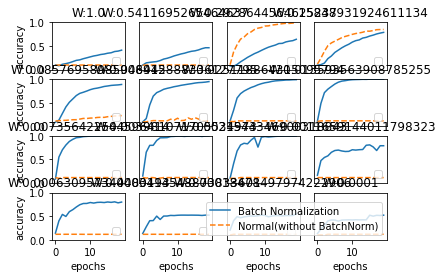

============1/16=============
epoch:0 | 0.094 - 0.093
epoch:1 | 0.097 - 0.134
epoch:2 | 0.097 - 0.151
epoch:3 | 0.097 - 0.16
epoch:4 | 0.097 - 0.179
epoch:5 | 0.097 - 0.194
epoch:6 | 0.097 - 0.197
epoch:7 | 0.097 - 0.206
epoch:8 | 0.097 - 0.231
epoch:9 | 0.097 - 0.242
epoch:10 | 0.097 - 0.259
epoch:11 | 0.097 - 0.272
epoch:12 | 0.097 - 0.283
epoch:13 | 0.097 - 0.294
epoch:14 | 0.097 - 0.305
epoch:15 | 0.097 - 0.319
epoch:16 | 0.097 - 0.337
epoch:17 | 0.097 - 0.351
epoch:18 | 0.097 - 0.363


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.371
============2/16=============
epoch:0 | 0.117 - 0.098


/content/drive/MyDrive/DL_from_bottom/common/multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/content/drive/MyDrive/DL_from_bottom/common/multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


epoch:1 | 0.097 - 0.096
epoch:2 | 0.097 - 0.113
epoch:3 | 0.097 - 0.121
epoch:4 | 0.097 - 0.136
epoch:5 | 0.097 - 0.153
epoch:6 | 0.097 - 0.173
epoch:7 | 0.097 - 0.196
epoch:8 | 0.097 - 0.222
epoch:9 | 0.097 - 0.249
epoch:10 | 0.097 - 0.283
epoch:11 | 0.097 - 0.311
epoch:12 | 0.097 - 0.352
epoch:13 | 0.097 - 0.375
epoch:14 | 0.097 - 0.389
epoch:15 | 0.097 - 0.404
epoch:16 | 0.097 - 0.419
epoch:17 | 0.097 - 0.434
epoch:18 | 0.097 - 0.46


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.478
============3/16=============
epoch:0 | 0.129 - 0.075
epoch:1 | 0.336 - 0.107
epoch:2 | 0.447 - 0.129
epoch:3 | 0.542 - 0.171
epoch:4 | 0.61 - 0.217
epoch:5 | 0.677 - 0.244
epoch:6 | 0.719 - 0.273
epoch:7 | 0.77 - 0.309
epoch:8 | 0.788 - 0.333
epoch:9 | 0.81 - 0.378
epoch:10 | 0.835 - 0.408
epoch:11 | 0.857 - 0.439
epoch:12 | 0.881 - 0.473
epoch:13 | 0.893 - 0.497
epoch:14 | 0.904 - 0.514
epoch:15 | 0.909 - 0.543
epoch:16 | 0.923 - 0.554
epoch:17 | 0.937 - 0.582
epoch:18 | 0.935 - 0.591


No handles with labels found to put in legend.


epoch:19 | 0.94 - 0.614
============4/16=============
epoch:0 | 0.094 - 0.092
epoch:1 | 0.271 - 0.09
epoch:2 | 0.423 - 0.152
epoch:3 | 0.527 - 0.225
epoch:4 | 0.594 - 0.281
epoch:5 | 0.644 - 0.355
epoch:6 | 0.682 - 0.408
epoch:7 | 0.7 - 0.463
epoch:8 | 0.747 - 0.516
epoch:9 | 0.752 - 0.552
epoch:10 | 0.768 - 0.58
epoch:11 | 0.788 - 0.625
epoch:12 | 0.81 - 0.648
epoch:13 | 0.807 - 0.672
epoch:14 | 0.824 - 0.703
epoch:15 | 0.832 - 0.723
epoch:16 | 0.838 - 0.735
epoch:17 | 0.853 - 0.759
epoch:18 | 0.861 - 0.768


No handles with labels found to put in legend.


epoch:19 | 0.863 - 0.779
============5/16=============
epoch:0 | 0.126 - 0.092
epoch:1 | 0.145 - 0.121
epoch:2 | 0.161 - 0.26
epoch:3 | 0.177 - 0.438
epoch:4 | 0.186 - 0.535
epoch:5 | 0.205 - 0.612
epoch:6 | 0.209 - 0.659
epoch:7 | 0.213 - 0.714
epoch:8 | 0.236 - 0.747
epoch:9 | 0.234 - 0.77
epoch:10 | 0.246 - 0.786
epoch:11 | 0.254 - 0.818
epoch:12 | 0.268 - 0.823
epoch:13 | 0.288 - 0.844
epoch:14 | 0.298 - 0.845
epoch:15 | 0.311 - 0.857
epoch:16 | 0.314 - 0.869
epoch:17 | 0.331 - 0.875
epoch:18 | 0.341 - 0.885


No handles with labels found to put in legend.


epoch:19 | 0.361 - 0.893
============6/16=============
epoch:0 | 0.107 - 0.1
epoch:1 | 0.083 - 0.191
epoch:2 | 0.107 - 0.453
epoch:3 | 0.124 - 0.583
epoch:4 | 0.125 - 0.641
epoch:5 | 0.151 - 0.676
epoch:6 | 0.136 - 0.72
epoch:7 | 0.154 - 0.76
epoch:8 | 0.116 - 0.786
epoch:9 | 0.116 - 0.825
epoch:10 | 0.116 - 0.843
epoch:11 | 0.116 - 0.862
epoch:12 | 0.116 - 0.867
epoch:13 | 0.116 - 0.882
epoch:14 | 0.116 - 0.888
epoch:15 | 0.116 - 0.896
epoch:16 | 0.116 - 0.905
epoch:17 | 0.116 - 0.923
epoch:18 | 0.116 - 0.93


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.93
============7/16=============
epoch:0 | 0.117 - 0.098
epoch:1 | 0.116 - 0.28
epoch:2 | 0.116 - 0.564
epoch:3 | 0.116 - 0.653
epoch:4 | 0.116 - 0.701
epoch:5 | 0.116 - 0.766
epoch:6 | 0.116 - 0.813
epoch:7 | 0.117 - 0.85
epoch:8 | 0.117 - 0.873
epoch:9 | 0.117 - 0.899
epoch:10 | 0.117 - 0.921
epoch:11 | 0.117 - 0.934
epoch:12 | 0.117 - 0.946
epoch:13 | 0.117 - 0.958
epoch:14 | 0.117 - 0.967
epoch:15 | 0.117 - 0.973
epoch:16 | 0.117 - 0.979
epoch:17 | 0.117 - 0.984
epoch:18 | 0.117 - 0.986


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.986
============8/16=============
epoch:0 | 0.094 - 0.135
epoch:1 | 0.116 - 0.461
epoch:2 | 0.116 - 0.698
epoch:3 | 0.116 - 0.762
epoch:4 | 0.116 - 0.808
epoch:5 | 0.116 - 0.84
epoch:6 | 0.116 - 0.886
epoch:7 | 0.116 - 0.929
epoch:8 | 0.116 - 0.951
epoch:9 | 0.116 - 0.965
epoch:10 | 0.116 - 0.982
epoch:11 | 0.116 - 0.987
epoch:12 | 0.116 - 0.994
epoch:13 | 0.116 - 0.996
epoch:14 | 0.116 - 0.996
epoch:15 | 0.116 - 0.997
epoch:16 | 0.117 - 0.999
epoch:17 | 0.116 - 0.998
epoch:18 | 0.117 - 0.999


No handles with labels found to put in legend.


epoch:19 | 0.117 - 1.0
============9/16=============
epoch:0 | 0.099 - 0.092
epoch:1 | 0.117 - 0.587
epoch:2 | 0.117 - 0.773
epoch:3 | 0.117 - 0.808
epoch:4 | 0.117 - 0.867
epoch:5 | 0.117 - 0.915
epoch:6 | 0.117 - 0.936
epoch:7 | 0.116 - 0.966
epoch:8 | 0.116 - 0.976
epoch:9 | 0.116 - 0.983
epoch:10 | 0.116 - 0.993
epoch:11 | 0.116 - 0.995
epoch:12 | 0.116 - 0.994
epoch:13 | 0.116 - 0.996
epoch:14 | 0.116 - 0.997
epoch:15 | 0.116 - 0.998
epoch:16 | 0.116 - 0.998
epoch:17 | 0.117 - 0.999
epoch:18 | 0.117 - 0.999


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.999
============10/16=============
epoch:0 | 0.094 - 0.135
epoch:1 | 0.099 - 0.662
epoch:2 | 0.116 - 0.847
epoch:3 | 0.116 - 0.896
epoch:4 | 0.116 - 0.957
epoch:5 | 0.116 - 0.965
epoch:6 | 0.116 - 0.953
epoch:7 | 0.116 - 0.986
epoch:8 | 0.116 - 0.985
epoch:9 | 0.116 - 0.996
epoch:10 | 0.116 - 0.995
epoch:11 | 0.116 - 0.997
epoch:12 | 0.116 - 0.996
epoch:13 | 0.116 - 0.997
epoch:14 | 0.116 - 0.999
epoch:15 | 0.116 - 0.999
epoch:16 | 0.116 - 0.999
epoch:17 | 0.116 - 0.999
epoch:18 | 0.116 - 1.0


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.999
============11/16=============
epoch:0 | 0.105 - 0.11
epoch:1 | 0.116 - 0.656
epoch:2 | 0.116 - 0.659
epoch:3 | 0.117 - 0.748
epoch:4 | 0.116 - 0.763
epoch:5 | 0.116 - 0.772
epoch:6 | 0.116 - 0.85
epoch:7 | 0.116 - 0.81
epoch:8 | 0.116 - 0.871
epoch:9 | 0.116 - 0.871
epoch:10 | 0.116 - 0.872
epoch:11 | 0.116 - 0.873
epoch:12 | 0.116 - 0.881
epoch:13 | 0.116 - 0.887
epoch:14 | 0.116 - 0.855
epoch:15 | 0.117 - 0.866
epoch:16 | 0.117 - 0.882
epoch:17 | 0.117 - 0.891
epoch:18 | 0.117 - 0.898


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.898
============12/16=============
epoch:0 | 0.105 - 0.119
epoch:1 | 0.116 - 0.269
epoch:2 | 0.117 - 0.671
epoch:3 | 0.117 - 0.71
epoch:4 | 0.117 - 0.503
epoch:5 | 0.117 - 0.768
epoch:6 | 0.117 - 0.772
epoch:7 | 0.116 - 0.786
epoch:8 | 0.116 - 0.795
epoch:9 | 0.117 - 0.718
epoch:10 | 0.117 - 0.782
epoch:11 | 0.116 - 0.792
epoch:12 | 0.117 - 0.723
epoch:13 | 0.117 - 0.801
epoch:14 | 0.117 - 0.78
epoch:15 | 0.117 - 0.809
epoch:16 | 0.117 - 0.811
epoch:17 | 0.117 - 0.814
epoch:18 | 0.117 - 0.816


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.817
============13/16=============
epoch:0 | 0.117 - 0.201
epoch:1 | 0.116 - 0.336
epoch:2 | 0.116 - 0.508
epoch:3 | 0.117 - 0.572
epoch:4 | 0.117 - 0.67
epoch:5 | 0.117 - 0.661
epoch:6 | 0.117 - 0.731
epoch:7 | 0.117 - 0.737
epoch:8 | 0.117 - 0.748
epoch:9 | 0.117 - 0.745
epoch:10 | 0.117 - 0.755
epoch:11 | 0.117 - 0.756
epoch:12 | 0.117 - 0.752
epoch:13 | 0.117 - 0.78
epoch:14 | 0.117 - 0.724
epoch:15 | 0.117 - 0.79
epoch:16 | 0.117 - 0.799
epoch:17 | 0.117 - 0.802
epoch:18 | 0.117 - 0.789


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.801
============14/16=============
epoch:0 | 0.116 - 0.138
epoch:1 | 0.117 - 0.443
epoch:2 | 0.116 - 0.493
epoch:3 | 0.117 - 0.494
epoch:4 | 0.117 - 0.457
epoch:5 | 0.117 - 0.473
epoch:6 | 0.117 - 0.485
epoch:7 | 0.117 - 0.513
epoch:8 | 0.117 - 0.498
epoch:9 | 0.117 - 0.56
epoch:10 | 0.117 - 0.588
epoch:11 | 0.117 - 0.525
epoch:12 | 0.117 - 0.603
epoch:13 | 0.117 - 0.533
epoch:14 | 0.117 - 0.613
epoch:15 | 0.117 - 0.621
epoch:16 | 0.117 - 0.624
epoch:17 | 0.117 - 0.597
epoch:18 | 0.117 - 0.601


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.57
============15/16=============
epoch:0 | 0.117 - 0.128
epoch:1 | 0.117 - 0.398
epoch:2 | 0.117 - 0.365
epoch:3 | 0.117 - 0.411
epoch:4 | 0.117 - 0.406
epoch:5 | 0.117 - 0.399
epoch:6 | 0.117 - 0.432
epoch:7 | 0.117 - 0.434
epoch:8 | 0.117 - 0.447
epoch:9 | 0.117 - 0.467
epoch:10 | 0.117 - 0.494
epoch:11 | 0.117 - 0.432
epoch:12 | 0.117 - 0.462
epoch:13 | 0.117 - 0.52
epoch:14 | 0.117 - 0.522
epoch:15 | 0.117 - 0.509
epoch:16 | 0.117 - 0.527
epoch:17 | 0.117 - 0.526
epoch:18 | 0.117 - 0.529


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.522
============16/16=============
epoch:0 | 0.116 - 0.299
epoch:1 | 0.117 - 0.318
epoch:2 | 0.117 - 0.405
epoch:3 | 0.117 - 0.422
epoch:4 | 0.116 - 0.418
epoch:5 | 0.117 - 0.41
epoch:6 | 0.117 - 0.422
epoch:7 | 0.117 - 0.425
epoch:8 | 0.117 - 0.426
epoch:9 | 0.117 - 0.428
epoch:10 | 0.117 - 0.432
epoch:11 | 0.117 - 0.431
epoch:12 | 0.117 - 0.431
epoch:13 | 0.117 - 0.433
epoch:14 | 0.117 - 0.427
epoch:15 | 0.116 - 0.498
epoch:16 | 0.116 - 0.516
epoch:17 | 0.116 - 0.513
epoch:18 | 0.116 - 0.529
epoch:19 | 0.117 - 0.515


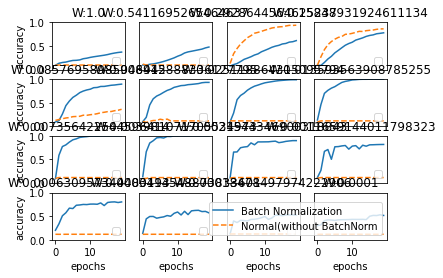

In [ ]:
from ch06.batch_norm_test import __train

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터 축소
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01

# 그래프 그리기
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print("============" + str(i+1) + "/16" + "=============")
    train_acc_list, bn_train_acc_list = __train(w)

    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--",markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')

plt.show()

거의 모든 경우에서 배치 정규화 사용시에 학습 진도가 빠른 것으로 나타남.<br/>
실제로 배치 정규화를 이용하지 않을 시에는 초깃값 분포가잘 되어 있지 않으면 학습이 전혀 진행되지 않음.<br/>
배치 정규화를 사용하면 학습이 빨라지며, 가중치 초깃값에 크게 의존하지 않아도 됨.

## 6.4 바른 학습을 위해


### 6.4.1 오버피팅
다음 경우에 주로 일어남
* 매개변수가 많고 표현력이 높은 모델
* 훈련 데이터가 적음<br/>

밑에서 일부로 오버피팅을 일으키고 관찰

In [ ]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)
# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 훈련
network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100,
                        100, 100, 100], output_size=10)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신
max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

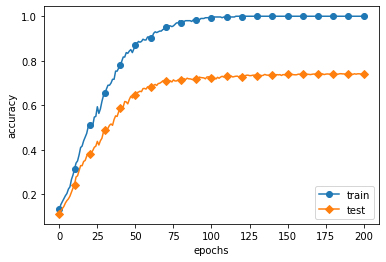

In [ ]:
# 정확도 그래프
plt.plot(train_acc_list, marker='o', label='train', markevery=10)
plt.plot(test_acc_list, marker='D', label='test', markevery=10)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc=4)
plt.show()

### 6.4.2 가중치 감소
* 큰 가중치에 대해서는 그에 상응하는 큰 페널티를 부과
* 원래 오버피팅은 가중치 매개변수의 값이 커서 발생하는 경우가 많음
* 가중치 감소는 모든 가중치 각각의 손실 함수에 $\frac{1}{2}\lambda W^2$을 더함
* 따라서 가중치의 기울기를 구하는 계산에서는 그동안의 오차역전파법에 따른 결과에 정규화 항을 미분한 $\lambda W$를 더한다

In [ ]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)
# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay(가중치 감쇠) 설정
weight_decay_lambda = 0.1

# 훈련
network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100,
                        100, 100], output_size=10, weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신
max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

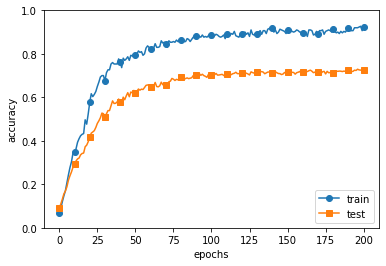

In [ ]:
# 그래프
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc=4)
plt.show()

### 6.4.3 드롭아웃
* 훈련 때 은닉층의 뉴런을 무작위로 골라 삭제

In [1]:
# 구현
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_fig=True):
        if train_fig:
            self.mask = np.random.rand(*shape) > self.dropout_ratio   # rand가 0~1 사이의 값을 고름
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask


mnist로 드롭아웃 효과 확인

In [2]:
import sys, os
path = '/content/drive/MyDrive/DL_from_bottom'
os.chdir(path)
sys.path.append(os.chdir)
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer
from common.optimizer import *

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅 재현 위해 학습 데이터 수 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# Dropout 사용 유무 and 비율 설정
use_dropout = True
dropout_ratio = 0.2

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)

trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)

trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list


train loss:2.3086503593082623
=== epoch:1, train acc:0.1, test acc:0.099 ===
train loss:2.3008070084778773
train loss:2.3035531761864445
train loss:2.302213375136237
=== epoch:2, train acc:0.10333333333333333, test acc:0.0975 ===
train loss:2.2843979363209486
train loss:2.27021332999847
train loss:2.2948666316972073
=== epoch:3, train acc:0.10666666666666667, test acc:0.0941 ===
train loss:2.321762640125103
train loss:2.3100693279034497
train loss:2.3033489609066153
=== epoch:4, train acc:0.09666666666666666, test acc:0.0927 ===
train loss:2.291006503479908
train loss:2.295372606194647
train loss:2.319095987989665
=== epoch:5, train acc:0.09666666666666666, test acc:0.0894 ===
train loss:2.308261646829881
train loss:2.3098965715512874
train loss:2.296408933463031
=== epoch:6, train acc:0.09666666666666666, test acc:0.0901 ===
train loss:2.3082416849466956
train loss:2.3191936399475797
train loss:2.291721229710995
=== epoch:7, train acc:0.10333333333333333, test acc:0.0893 ===
train los

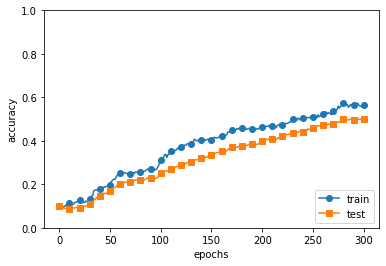

In [3]:
# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.legend(loc=4)
plt.show()

train과 test사이의 차이가 상당히 줄어듬

## 6.5 적절한 하이퍼파라미터 값 찾기

### 6.5.1 검증 데이터
* 하이퍼파라미터를 검증할 때는 시험 데이터를 사용하면 안됨
* 하이퍼파라미터 조정용 데이터를 일반적으로 검증데이터(validation data)라고 부름
> * 훈련 데이터 : 매개변수 학습
> * 검증 데이터 : 하이퍼파라미터 성능 평가
> * 시험 데이터 : 신경망의 범용 성능 평가

In [9]:
from common.util import shuffle_dataset

(x_train, t_train), (x_test, t_test) = load_mnist()

# 훈련 데이터를 뒤섞는다
x_train, t_train = shuffle_dataset(x_train, t_train)

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

### 6.5.2 하이퍼파라미터 최적화
* 하이퍼파라미터의 '최적 값'이 존재하는 범위를 조금씩 줄여나감
* 그리드 서치같은 규칙적인 탐색보단 무작위로 샘플링해 탐색하는 편이 좋은 결과를 냄
* 최종 정확도에 미치는 영향력이 각자 다르기 때문
* 0.001~1000과 같이 로그 스케일로 지정
* 학습을 위한 에폭을 작게 하여, 1회 평가에 걸리는 시간을 단축하는 것이 효율적
>* 0단계<br/>
하이퍼파라미터 값의 범위를 설정
>* 1단계<br/>
설정된 범위에서 하이퍼파라미터의 값을 무작위 추출
>* 2단계<br/>
1단계에서 샘플링한 하이퍼파라미터 값을 사용하여 학습하고, 검증 데이터로 정확도 평가(에폭은 작게 설정)
>* 3단계<br/>
1단계와 2단계를 특정횟수 (100회 등) 반복하며, 그 정확도의 결과를 보고 하이퍼파라미터의 범위를 좁힌다.

더 세련된 기법을 원한다면 '베이즈 최적화' 찾아볼것<br/>
https://data-scientist-brian-kim.tistory.com/88

### 6.5.3 하이퍼파라미터 최적화 구현

In [12]:
# 하이퍼파라미터 무작위 추출
weight_decay = 10 ** np.random.uniform(-8, -4)
lr = 10 ** np.random.uniform(-6, -2)
print(lr)

3.4607382916841175e-05


val acc:0.05 | lr:6.46441995280925e-05, weight decay:9.270962352943056e-08
val acc:0.08 | lr:8.005709548683679e-06, weight decay:2.0458227556417174e-08
val acc:0.8 | lr:0.009167115464518242, weight decay:7.979271515344389e-08
val acc:0.12 | lr:0.00028478517611709933, weight decay:1.1154962593723411e-07
val acc:0.8 | lr:0.006438610237709757, weight decay:3.8813033743685536e-08
val acc:0.05 | lr:7.87947508675313e-06, weight decay:6.287320982492571e-06
val acc:0.2 | lr:0.0007050545447774044, weight decay:1.0916003249954473e-05
val acc:0.12 | lr:9.159651632719887e-05, weight decay:1.4483435477903214e-06
val acc:0.3 | lr:0.0019523868292646515, weight decay:2.3167606536465663e-08
val acc:0.1 | lr:4.059327297969987e-05, weight decay:4.4585187924251404e-05
val acc:0.7 | lr:0.005140943245988782, weight decay:3.328972097750097e-06
val acc:0.07 | lr:1.5004403120162785e-06, weight decay:1.0965177865773508e-07
val acc:0.1 | lr:0.00015674993201738116, weight decay:3.676522873330246e-05
val acc:0.13 

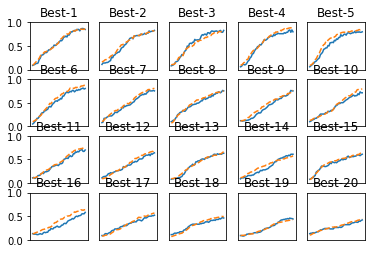

NameError: ignored

In [13]:
import ch06.hyperparameter_optimization

hyperparameter_optimization